going to try and deal with the outliers now, two ways i can think of that ill do:
- dont touch new listings untill a period of time has passed

- size risk by recent realised volatility of returns

In [92]:
# importing packages and data

import pandas as pd
import matplotlib.pyplot as plt
import math

df = pd.read_csv("extended_data.csv", 
dtype={0: float, 1: str, 2: float,  3: float,  4: float,  5: float,  6: float,  7: float,  8: int}
)

# fill missed funding periods with 0
df["funding"] = df["funding"].fillna(0)

# check number of assets
print(len(df["asset"].unique()))

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

57
Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate]
Index: []


In [93]:
# making time readable
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# getting returns and return and funding volatility

# asset retuns
df["returns"] = (
    df.groupby("asset")["close"]
      .transform(lambda x: x.pct_change())
)

# asset returns inclusive of funding
df["returns_funding"] = df["returns"] - df["funding"]

VOLATILITY_LOOKBACK = 30
TARGET_VOLATILITY = 1/math.sqrt(365)
print(TARGET_VOLATILITY)

# asset returns and funding volatility
df["rolling_returns_funding_vol"] = (
    df.groupby("asset")["returns_funding"]
      .rolling(window=VOLATILITY_LOOKBACK)
      .std()
      .reset_index(level=0, drop=True)
)

# next day asset returns inclusive of funding
df["next_returns_funding"] = (
    df.groupby("asset")["returns_funding"]
      .shift(-1)
)
# scaling returns and funding by volatility
df["returns_funding_volscaled"] = df["returns_funding"]*(TARGET_VOLATILITY/df["rolling_returns_funding_vol"])

# next day asset returns inclusive of funding volatility scaled
df["next_returns_funding_vs"] = (
    df.groupby("asset")["returns_funding_volscaled"]
      .shift(-1)
)

0.052342392259021375


In [94]:
# editing to remove what wont yet include returns and final day
df = df[df.groupby('asset').cumcount() > 1].copy()
df = df.groupby('asset').head(-1).copy()

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

                timestamp         asset      open      high       low  \
2     2024-12-08 20:00:00  1000BONK-USD  0.043347  0.043951  0.043347   
3     2024-12-09 20:00:00  1000BONK-USD  0.043403  0.043420  0.032714   
4     2024-12-10 20:00:00  1000BONK-USD  0.034959  0.040022  0.034183   
5     2024-12-11 20:00:00  1000BONK-USD  0.039732  0.040765  0.038059   
6     2024-12-12 20:00:00  1000BONK-USD  0.038122  0.040204  0.036962   
...                   ...           ...       ...       ...       ...   
14015 2025-09-15 20:00:00      ZORA-USD  0.074516  0.082737  0.070157   
14016 2025-09-16 20:00:00      ZORA-USD  0.077085  0.078780  0.071211   
14017 2025-09-17 20:00:00      ZORA-USD  0.074389  0.076835  0.071054   
14018 2025-09-18 20:00:00      ZORA-USD  0.071066  0.071453  0.064000   
14019 2025-09-19 20:00:00      ZORA-USD  0.064000  0.065281  0.063238   

          close      volume   funding  funding inaccurate   returns  \
2      0.043403    309700.0  0.001401               

In [95]:
idx_max = df["next_returns_funding"].idxmax()
print(df.loc[idx_max])
idx_min = df["next_returns_funding"].idxmin()
print(df.loc[idx_min])

timestamp                      2025-05-07 20:00:00
asset                                  MOODENG-USD
open                                       0.03772
high                                       0.06749
low                                        0.03772
close                                      0.06609
volume                                  34510390.0
funding                                   0.000036
funding inaccurate                              24
returns                                   0.752121
returns_funding                           0.752085
rolling_returns_funding_vol               0.153059
next_returns_funding                      1.070981
returns_funding_volscaled                 0.257195
next_returns_funding_vs                   0.231936
Name: 7811, dtype: object
timestamp                      2025-08-30 20:00:00
asset                                      XPL-USD
open                                       0.72323
high                                       0.87782
low  

In [96]:
# create funding deciles
df["funding_decile"] = 0

# per day deciles across all assets
df['funding_decile'] = df.groupby('timestamp')['funding'] \
    .transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))

# check df
unique_times = df["timestamp"].unique()
#print(unique_times)
print(df[df["timestamp"] == unique_times[0]])

                timestamp         asset           open           high  \
2     2024-12-08 20:00:00  1000BONK-USD       0.043347       0.043951   
418   2024-12-08 20:00:00  1000PEPE-USD       0.026539       0.028275   
708   2024-12-08 20:00:00  1000SHIB-USD       0.030642       0.030642   
1357  2024-12-08 20:00:00       ADA-USD       1.233100       1.233100   
1798  2024-12-08 20:00:00       ARB-USD       1.150300       1.162700   
2217  2024-12-08 20:00:00      AVAX-USD      52.760000      54.440000   
2855  2024-12-08 20:00:00       BNB-USD     739.400000     744.100000   
3278  2024-12-08 20:00:00       BTC-USD  100174.000000  101267.700000   
3726  2024-12-08 20:00:00      DOGE-USD       0.461790       0.467290   
4421  2024-12-08 20:00:00       ETH-USD    3996.470000    4015.000000   
4967  2024-12-08 20:00:00      GOAT-USD       0.780800       0.780800   
6697  2024-12-08 20:00:00      LINK-USD      25.923000      27.308000   
7103  2024-12-08 20:00:00       LTC-USD     133.490

first plotting is all assets without first week of data

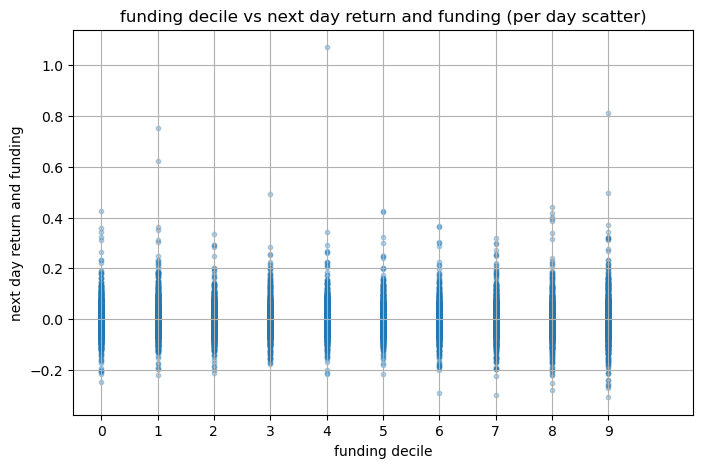

In [97]:
# scatter plot to gain initial intuiton

df1 = df[df.groupby('asset').cumcount() > 6].copy()

plt.figure(figsize=(8,5))
plt.scatter(
    df1["funding_decile"], 
    df1["next_returns_funding"], 
    alpha=0.3, 
    s=10
)

plt.xlabel("funding decile")
plt.ylabel("next day return and funding")
plt.title("funding decile vs next day return and funding (per day scatter)")
plt.grid(True)

plt.xlim(-0.5, 10.5)
plt.xticks(range(0, 10))
plt.show()

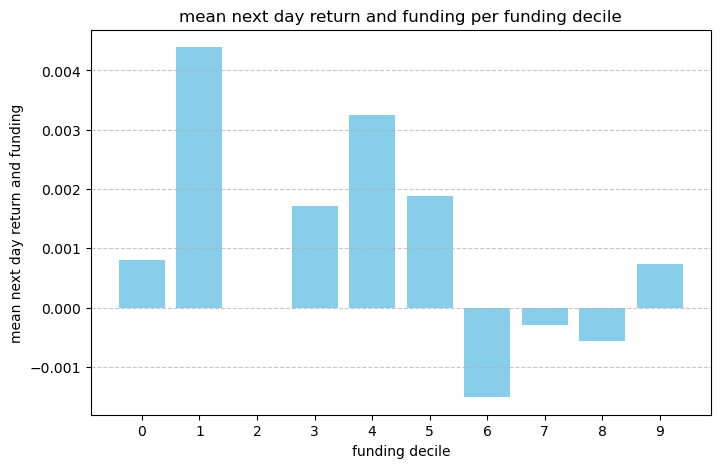

In [98]:
# decile plot to aim to see effects more clearly
decile_means = df.groupby("funding_decile")["next_returns_funding"].mean()

plt.figure(figsize=(8,5))
plt.bar(decile_means.index, decile_means.values, color="skyblue")
plt.xlabel("funding decile")
plt.ylabel("mean next day return and funding")
plt.title("mean next day return and funding per funding decile")
plt.xticks(decile_means.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

okay no decent evidence that dropping the first week of data for each asset has helped significantly; will try volatility scaling now

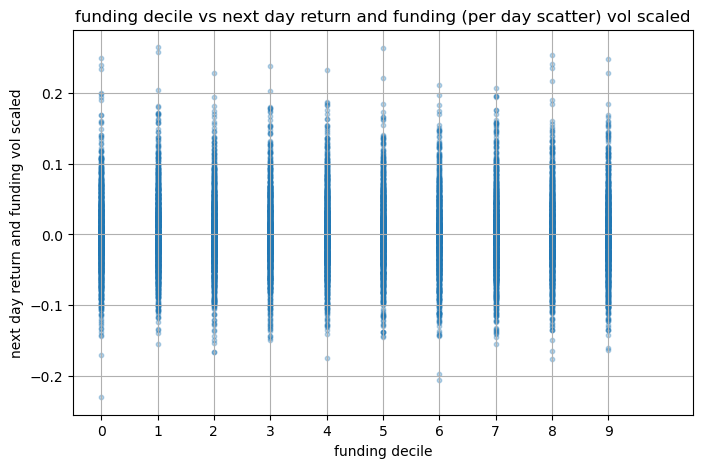

In [99]:
# scatter plot to gain initial intuiton
plt.figure(figsize=(8,5))
plt.scatter(
    df["funding_decile"], 
    df["next_returns_funding_vs"], 
    alpha=0.3, 
    s=10
)

plt.xlabel("funding decile")
plt.ylabel("next day return and funding vol scaled")
plt.title("funding decile vs next day return and funding (per day scatter) vol scaled")
plt.grid(True)

plt.xlim(-0.5, 10.5)
plt.xticks(range(0, 10))
plt.show()

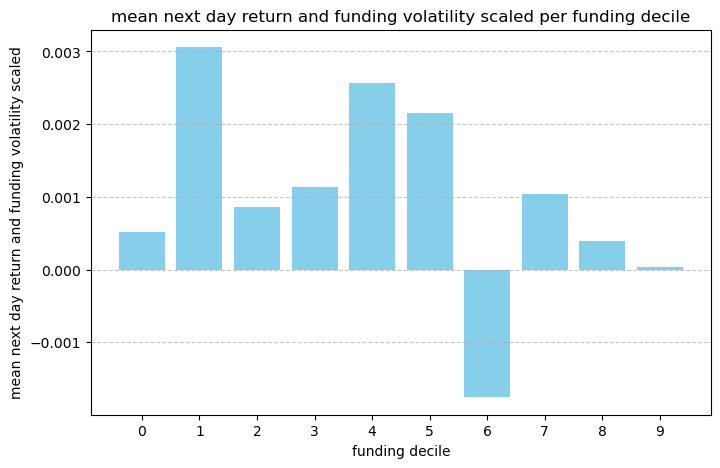

In [100]:
# decile plot to aim to see effects more clearly
decile_means = df.groupby("funding_decile")["next_returns_funding_vs"].mean()

plt.figure(figsize=(8,5))
plt.bar(decile_means.index, decile_means.values, color="skyblue")
plt.xlabel("funding decile")
plt.ylabel("mean next day return and funding volatility scaled")
plt.title("mean next day return and funding volatility scaled per funding decile")
plt.xticks(decile_means.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

volatility scaling seems to have helped, to explain clearly - the mean returns have not improved in a way that would be useful to me but the variance around them has been tightened

also is worth mentioning that my volaility estimate takes 30 days to get so new listings arent going to be included anyway if i do this

to be more confident im going to cut out the top and bottom 2% of returns and check if the decile means change meaningfully

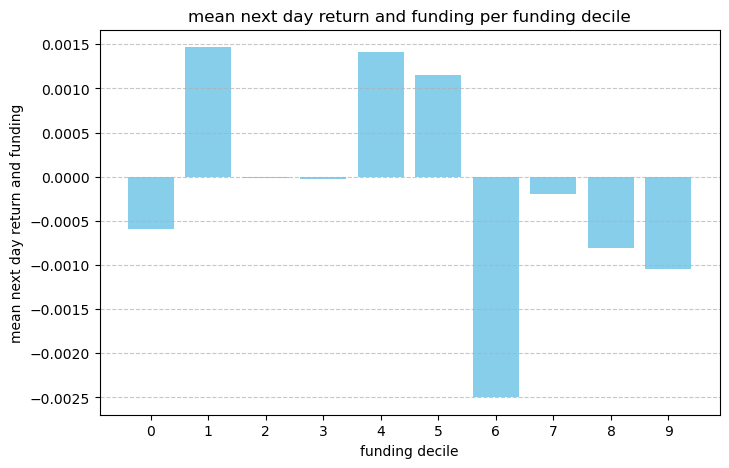

In [101]:
decile_means_v2 = (
    df.groupby("funding_decile")["next_returns_funding_vs"]
      .apply(lambda g: g[
          (g >= g.quantile(0.05)) &
          (g <= g.quantile(0.95))
      ].mean())
)

plt.figure(figsize=(8,5))
plt.bar(decile_means_v2.index, decile_means_v2.values, color="skyblue")
plt.xlabel("funding decile")
plt.ylabel("mean next day return and funding")
plt.title("mean next day return and funding per funding decile")
plt.xticks(decile_means_v2.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

it can be seen from the plot that they dont change meaningfully - this is probably confusing as they look different so let me clarify: if you were to trade this information youd probably long 0-5 and short 6-9, the difference in decile value means hasent changed in a way that would make your decided longs or shorts lose money (historically)

now weve got two things:
- some basics on how to manage risk (volatility scale), or more precisely - how it was sensible to manage risk historically, if you missed this think of how you benefit from less volatility around the mean return

- less naivety of our returns (if ive made you slightly paranoid, good - you should be)